# Baseline Analysis

Now that we have cleaned our data and removed duplicates, we can take a look at some basic features of the dataset and answer some basic questions about shots and goals. What types of shots are the most common? What types of shots are the most successful? Where on the ice to shots and goals typically occur?

In [14]:
# import needed analysis and visualization libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path where our pickle files are stored
PICKLE_PATH = Path("../pickled_data/")

# Read in the plays data
game_plays = pd.read_pickle(PICKLE_PATH / 'game_plays')

In [2]:
game_plays.dtypes

play_id                 object
game_id                  int64
team_id_for            float64
team_id_against        float64
event                   object
secondaryType           object
x                      float64
y                      float64
period                   int64
periodType              object
periodTime               int64
periodTimeRemaining    float64
dateTime                object
goals_away               int64
goals_home               int64
description             object
st_x                   float64
st_y                   float64
dtype: object

In [3]:
game_plays['event'].value_counts()

event
Faceoff                     743979
Shot                        698365
Hit                         587574
Stoppage                    581172
Blocked Shot                358851
Missed Shot                 296389
Penalty                     229228
Giveaway                    219864
Takeaway                    173246
Goal                        133345
Period Start                 41663
Period Ready                 41614
Period End                   41609
Period Official              41608
Game End                     12462
Game Scheduled               12458
Shootout Complete             1274
Game Official                 1267
Official Challenge            1028
Early Intermission Start        31
Early Intermission End          31
Emergency Goaltender             5
Name: count, dtype: int64

In [9]:
game_plays[game_plays['event'] == 'Shot']['secondaryType'].unique()

array(['Wrist Shot', 'Slap Shot', 'Tip-In', 'Snap Shot', 'Backhand',
       'Deflected', 'Wrap-around'], dtype=object)

### Shots and Goals by Type

We can filter our data down to a DataFrame for shots (rows where 'event' column is 'Shot') and a DataFrame for goals (rows where 'event' column is 'Goal'). We include the 'secondaryType' column as it stores the Shot Type. Shot types are broken down into

- Wrist shot
- Slap shot
- Snap shot
- Backhand 
- Deflected
- Tip In
- Wrap-around 

In [15]:
# Shots by shot type
shots = game_plays[game_plays['event'] == 'Shot']
shot_count = shots.groupby('secondaryType')['play_id'].count().sort_values(ascending=False)

In [16]:
# Goals by shot type
goals = game_plays[game_plays['event'] == 'Goal']
goal_count = goals.groupby('secondaryType')['play_id'].count().sort_values(ascending=False)

We use a stacked bar chart to show shot and goal frequency by type.

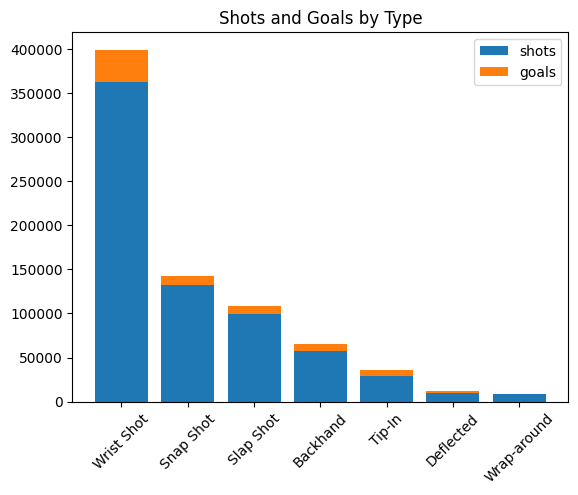

In [6]:
# create a stacked bar with shots and goal separated by type
shot_types = goal_count.index
counts = {
    "shots": shot_count,
    "goals": goal_count
}

fig, ax = plt.subplots()
bottom=np.zeros(len(goal_count))
for name, count in counts.items():
    ax.bar(shot_types, count, label=name, bottom=bottom)
    bottom += count
    
ax.set_title('Shots and Goals by Type')
ax.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()


We see that the most common shot by far is Wrist shots, followed by Snap and slap shots. This makes sense as these are the "easiest" shots to take. Backhand shots require space and some movement across the ice to be able to lift the puck, and players typically more confident on the forehand. Tip-ins, deflections, and wrap-arounds require coordination and opportunity, whereas the more common types can be attempted at any time with an open lane. Since wrist shots are much more common, this plot degrades the information of "how successful" each shot type is. 

We can get a better look at how successful shot types are at producing goals by introducing accuracy. Here we define accuracy by how many goals were scored from a particular shot type divided by the number of shots of that type were taken. We then plot the accuracy in bar chart where each bar represents a certain shot type.

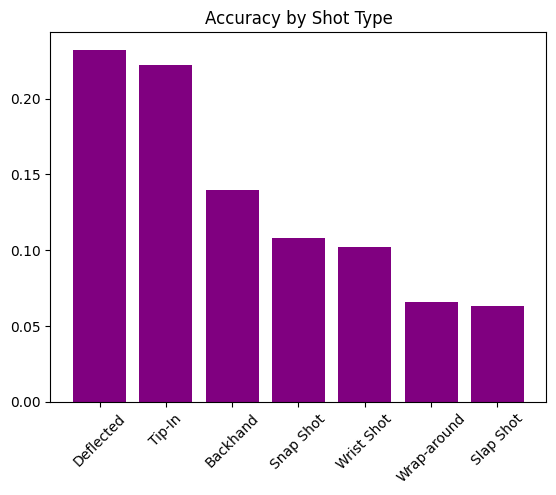

In [13]:
# Plot accuracy (goals/shots) for shot types
accuracy = goal_count / shot_count
accuracy.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
ax.bar(accuracy.index, accuracy, color="purple")

ax.set_title("Accuracy by Shot Type")
plt.xticks(rotation=45)
plt.show()

We see that Deflected shots and Tip-In shots are the most succesful, but are some of the least attempted shots. Deflections are when a player in front of the net has the puck hit or "deflect" off their stick or body and then travel into the net. Tip-ins are when a player receives a pass or rebound and shoots them directly or "tips" them into the net. Since both these shot types require coordination between teammates, the opportunity may not arise as frequently. Similarly, many wrist, snap, or slap shots may be attempts at deflections that do not succeed as intended.

Another reason for the high frequency of less accurate shots is that they are "easier" to take. The time and space required for a snap shot or wrist shot is minimal compared to a backhand, where player must extend their stick away from their body to hold the puck on the back of their stick where they may have less control. 

### Correcting coordinates

Our (x,y) coordinates are provided on a plane where center ice is the origin (0, 0), the x coordinate is distance in feet along the length of the ice, and the y coordinate is distance in feet along the width of the ice. Play occurs on both "sides" of the plane, so that plays that occur on the left side of the ice will have negative x values, while those that occur on the right side of the ice will have positive x values. Since our analysis and visualization is inspecting play as a whole, and not the performance of individual teams, we can produce more focused distributions and visualizations by focusing on one side of the ice.

To accomplish this, we transform or "correct" the x and y coordinates so that they all occupy one side. For the x coordinate, we simply take the absolute value, so that all plays appear to occur on the right side of the ice. For the y coordinate, we must "flip" the coordinate over the x axis to occur for the shift in perspective on the left vs. the right. For example, on the left side of the ice a player facing goal has positive y coordinates to their right hand side, and negative coordinates to their left hand side. The right side of the ice is the exact opposite. We flip the the coordinate by multiplying by the sign of the x coordinate.

In [17]:
# Add count columns for counting goals and shots, to be used in density based visualizations later on.
game_plays['goal'] = (game_plays['event'] == "Goal").astype(int)
game_plays['shot'] = (game_plays['event'] == "Shot").astype(int)

# Correct the x and y coordinates to occupy only one side of the ice
game_plays['xC'] = np.abs(game_plays['x'])
game_plays['yC'] = game_plays['y'] * np.sign(game_plays['x'])

# filter for goals and missing coordinates
goals = game_plays.loc[
    ~game_plays["xC"].isna() &
    ~game_plays["yC"].isna() &
    (game_plays['event'].isin(["Goal"]))
]
# keep only columns we need for performance in drawing density plots
goals = goals[['xC', 'yC', 'goal', 'secondaryType']]

# repeat for shots
# filter for shots and missing coordinates
shots = game_plays.loc[
    ~game_plays["xC"].isna() &
    ~game_plays["yC"].isna() &
    (game_plays['event'].isin(["Shot"]))
]
# keep only columns we need for performance in drawing density plots
shots = shots[['xC', 'yC', 'shot', 'secondaryType']]

Since we are given the (x,y) coordinates of our events, we can also calculate the distance from the goal, and the angle of the shooter to the goal using some geometry.

The distance can be found simply using the Pythagorean distance. We can approximate the location of the goal as the center of it's opening at (89, 0). Then we can use the following formula to calculate the distance: 

$$D = \sqrt {(x - 89)^2 + (y - 0)^2}$$ 

We can measure the angle of the shot as the angle of intersection with an imaginary line down the center of the ice. We can also think of this as the angle a goaltender would have to apply to be completely "square" to the shot. This angle can be calculated using the formula: 

$$\theta = \tan^{-1} ({\frac {y}{89 - x}}) * \frac {180}{\pi}$$

Distance and angle (theta) are illustrated through the plot below:

[Text(77, 4, 'distance')]

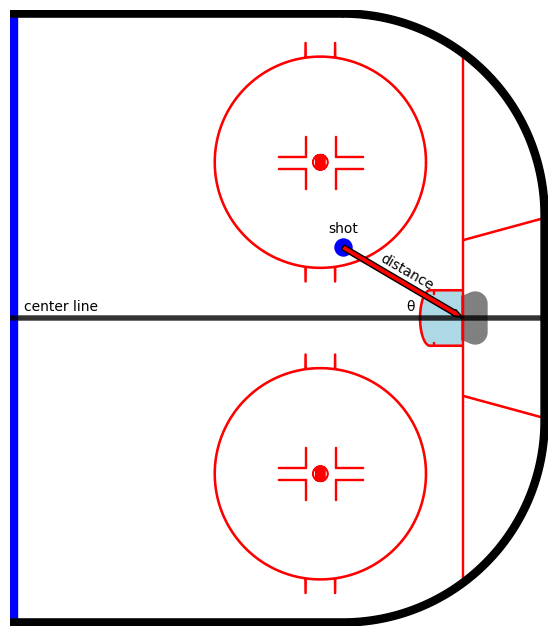

In [ ]:
# Center of goal is (89, 0)
from hockey_rink import NHLRink # this package allows annotation of the rink 

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl = NHLRink()
nhl.draw(ax = ax, display_range = "ozone")

nhl.scatter(x=72, y=10, color='blue', s=150)
nhl.arrow(x=72, y=10, x2=89, y2=0, facecolor = "red", length_includes_head=True, head_width=1)
nhl.arrow(x=25, y=0, x2=110, y2=0, facecolor="black", head_width=None, linestyle='--', linewidth=0.1, alpha=0.8)
nhl.text(x=70, y=12, s="shot")
nhl.text(x=81, y=1, s="θ")
nhl.text(x=27, y=1, s="center line")
nhl.text(x=77, y=4, s="distance", rotation=-30)

Let's apply our distance and angle formulas to the shots DataFrame to produce and distance column and angle column for each shot in the dataset.

In [102]:
# Calculate shot distance column
shots['distance'] = shots[['xC', 'yC']].apply(
    lambda row: np.sqrt((row['xC'] - 89)**2 + row['yC']**2),
    axis=1
    )
# Calculate shot angle column
shots['angle'] = shots[['xC', 'yC']].apply(
    lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi), 
    axis=1
    )

/tmp/ipykernel_148839/213725400.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi),


### Shot Distance and Angle

We then plot the distributions of shot distance alongside their Kernel Density Estimation. This shows us how distance from goal when a shot is taken is distributed.

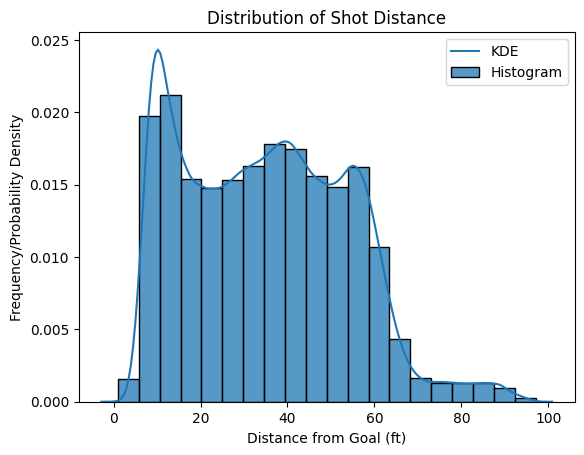

In [113]:
sns.histplot(shots['distance'], bins=20, stat="density", label="Histogram")
sns.kdeplot(shots['distance'], label='KDE') 

plt.xlabel("Distance from Goal (ft)")
plt.ylabel("Frequency/Probability Density")
plt.title("Distribution of Shot Distance")
plt.legend()
plt.show()

We see there are very few shots taken from in or near the crease (0-5 ft), but shots are most frequent between 5-15 ft away from goal, then fairly evenly distributed along the length of the ice from there, until the frequency drops off steeply near the end of the offensive zone. Some shots are taken from outside the offensive zone, which makes sense, some of these will be shots at an empty net, but others will be players "dumping" the puck into the offensive zone, hoping that the goalie will freeze the puck or deflect it into a corner where their team can re-take possession.

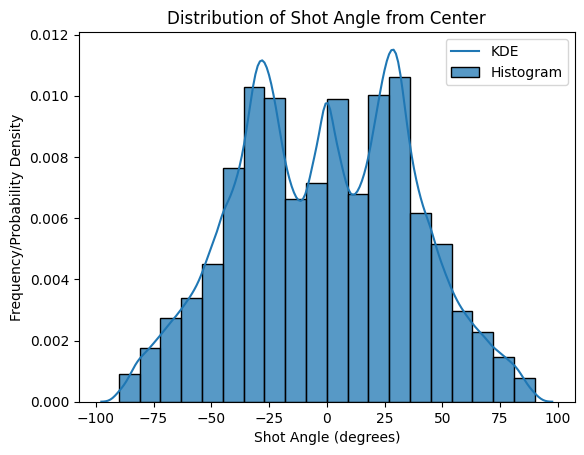

In [114]:
sns.histplot(shots['angle'], bins=20, stat="density", label="Histogram")
sns.kdeplot(shots['angle'], label='KDE') 

plt.xlabel("Shot Angle (degrees)")
plt.ylabel("Frequency/Probability Density")
plt.title("Distribution of Shot Angle from Center")
plt.legend()
plt.show()

Here, we see that the angle at which a player shoots has a fairly symmetrical distribution, where shots are common in the middle of the ice, but most common at a 20-30 degree angle off center. This is common offensive positioning for the wing players, as well as the defensemen playing offense, where each stand slightly left or right of center. Another possible source of these angles are net front plays, where one player will pass across the crease to another in order to catch the goalie sliding from one side of the net to the other and thus, have a larger area to shoot at. 

In [109]:
goals['distance'] = goals[['xC', 'yC']].apply(
    lambda row: np.sqrt((row['xC'] - 89)**2 + row['yC']**2),
    axis=1
    )
# Calculate shot angle column
goals['angle'] = goals[['xC', 'yC']].apply(
    lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi), 
    axis=1
    )

/tmp/ipykernel_148839/858300658.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi),
/tmp/ipykernel_148839/858300658.py:7: RuntimeWarning: invalid value encountered in scalar divide
  lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi),


### Goal Distance and Angle

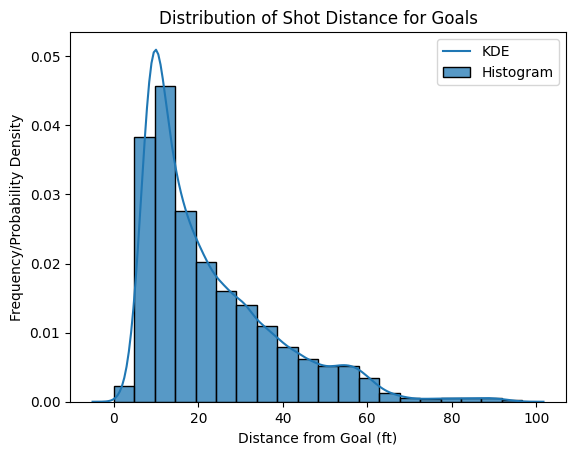

In [115]:
sns.histplot(goals['distance'], bins=20, stat="density", label="Histogram")
sns.kdeplot(goals['distance'], label='KDE') 

plt.xlabel("Distance from Goal (ft)")
plt.ylabel("Frequency/Probability Density")
plt.title("Distribution of Shot Distance for Goals")
plt.legend()
plt.show()

We see that Goals have a much higher frequency close in to the net. We see the same low rate in tight to the goal crease (0-5ft), but that nearly all goals are scored from 5-20 ft before steeply dropping off in frequency. The likelihood of scoring from past the faceoff circles is very low, though we still see a high frequency of shots from their. This again, is likely due to the "ease" of the shots. Defensively, teams protect the middle of the ice, leaving the walls and top of the zone where defenseman on offense are positioned more open in order to prioritize stopping forwards from occupying the center of the ice and locations close to the net. These leaves farther shots "open" to be attempted, hoping to generate deflection attempts, or rebounds for players on their team to retrieve

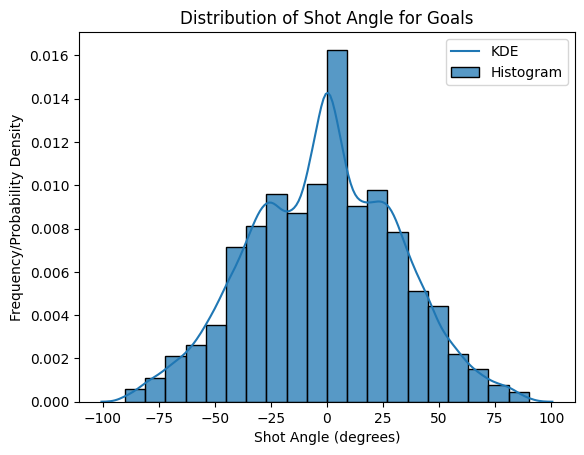

In [116]:
sns.histplot(goals['angle'], bins=20, stat="density", label="Histogram")
sns.kdeplot(goals['angle'], label='KDE') 

plt.xlabel("Shot Angle (degrees)")
plt.ylabel("Frequency/Probability Density")
plt.title("Distribution of Shot Angle for Goals")
plt.legend()
plt.show()

We see that shot angle for goals is distributed much closer to center ice than general shots. Shots like deflections, tip-ins, backhands, and wrap-around will *always* occur from these shallow angles, and those have a high success rate. Also, this speaks to "play-driving" shots or the mentality of "pucks to the net". Players shoot from all over to drive play, hoping for rebounds, tips, deflections or goalie mistakes. A shot is often just an effective way to get the puck near goal, which is the most common area to score from. This may explain the marked difference we see in these distributions

### Shot Location Density Visualization

Seeing the distributions of distance and angle effectively explain shot patterns and scoring patterns. However, we seek a more accessible visualization that give better context to the game we are discussing. In the following visualizations, we use `sportpy`, an open source visualization library for sports. The library provides methods to plot playing surfaces for different sports, in this case we are only interested in hockey. The library also wraps `matplotlib` functions for use in displaying visualizations overlaid on the playing surface. Let's experiment with showing different density visualizations like `hexbin` and `heatmap` to display where shots and goals occur most often on the ice. 

#### Hexbins
We first show the density for shots and goals with a hexbin. Where each bin is a hexagon with a defined binsize and all data occurring within the area of that hexgon contributes to the density for that area. High density is show as red, while low density is shown in blue, and middling density is shown on a gradient between the two.

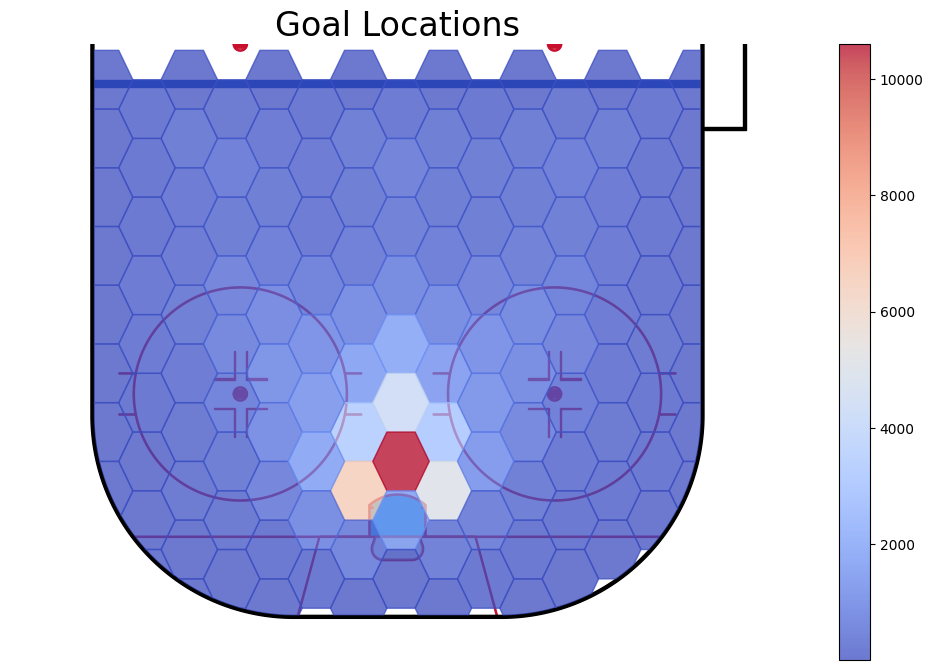

In [ ]:
from sportypy.surfaces.hockey import NHLRink

nhl = NHLRink()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl.draw(ax, display_range="ozone", rotation=270)
hex = nhl.hexbin(
    goals["xC"],
    goals["yC"],
    values = goals["goal"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    binsize = (8, 12),
    zorder=30,
    alpha=0.75
)

ax.set_title("Goal Location Density", fontsize=24)
plt.colorbar(hex, ax=ax)

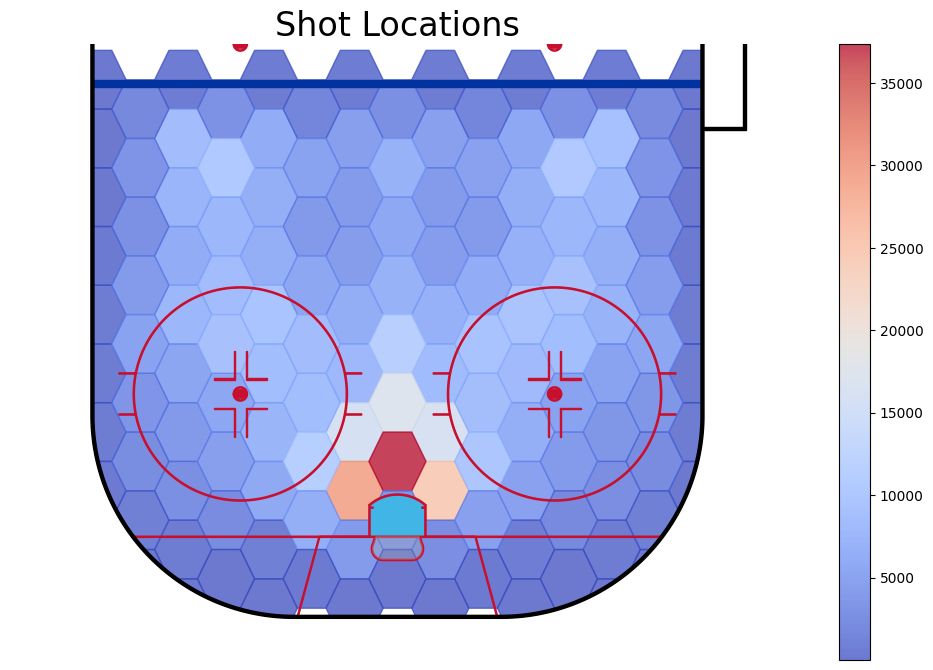

In [86]:
nhl = NHLRink()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl.draw(ax, display_range="ozone", rotation=270)
hex = nhl.hexbin(
    shots["xC"],
    shots["yC"],
    values = shots["shot"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    binsize = (8, 12),
    zorder=5,
    alpha=0.75
)

ax.set_title("Shot Locations", fontsize=24)
plt.colorbar(hex, ax=ax)

#### Heatmaps

We will repeat the same density visualization approach with a heatmap visualization 

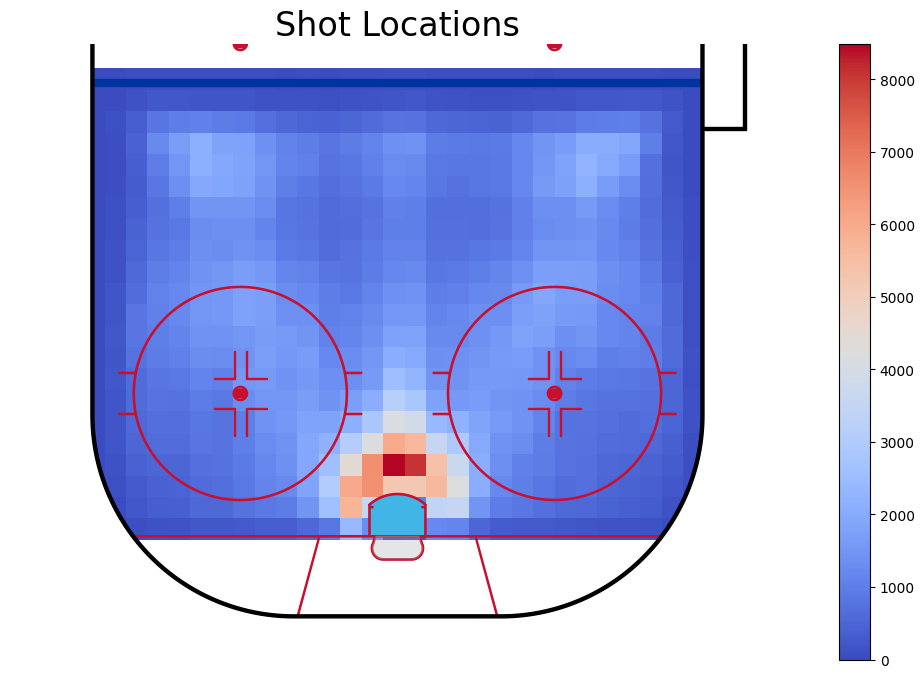

In [ ]:
nhl = NHLRink()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl.draw(ax, display_range="ozone", rotation=270)
heat = nhl.heatmap(
    shots["xC"],
    shots["yC"],
    values = shots["shot"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    plot_xlim=(25, 89),
    binsize=3, 
    alpha=0.85
)

ax.set_title("Shot Locations", fontsize=24)
plt.colorbar(heat, ax=ax)

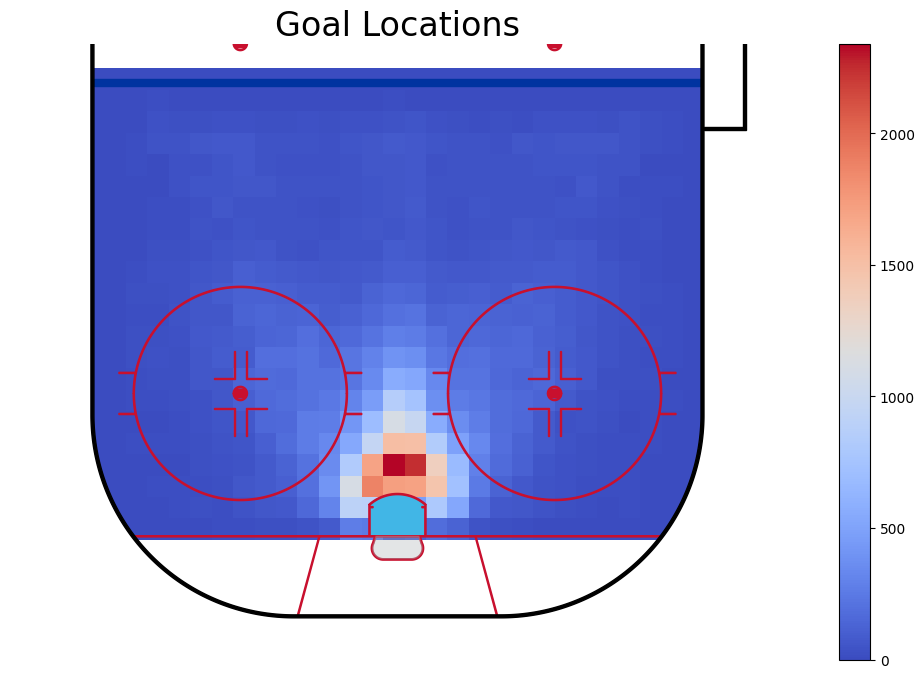

In [ ]:
nhl = NHLRink()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl.draw(ax, display_range="ozone", rotation=270)
heat = nhl.heatmap(
    goals["xC"],
    goals["yC"],
    values = goals["goal"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    plot_xlim=(25, 89),
    binsize=3,
    alpha=0.85
)

ax.set_title("Goal Locations", fontsize=24)
plt.colorbar(heat, ax=ax)

Comparing the two density plot types, we prefer the heatmap. The heatmap provides a higher definition with its smaller bin size and a more consistent handling of areas where data is sparse, whereas the hexbin may have empty white spaces inconsistently along the boards or other areas where there is little data. Despite the hexbin being a bit more visually pleasing, it comes at the cost of visual data.

#### Locations by Shot type

Let's repeat this visualization for each shot type in our shots and goals dataframes to see where each particular shot type occurs most, and where they are most often producing goals.

/tmp/ipykernel_853/3339653872.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


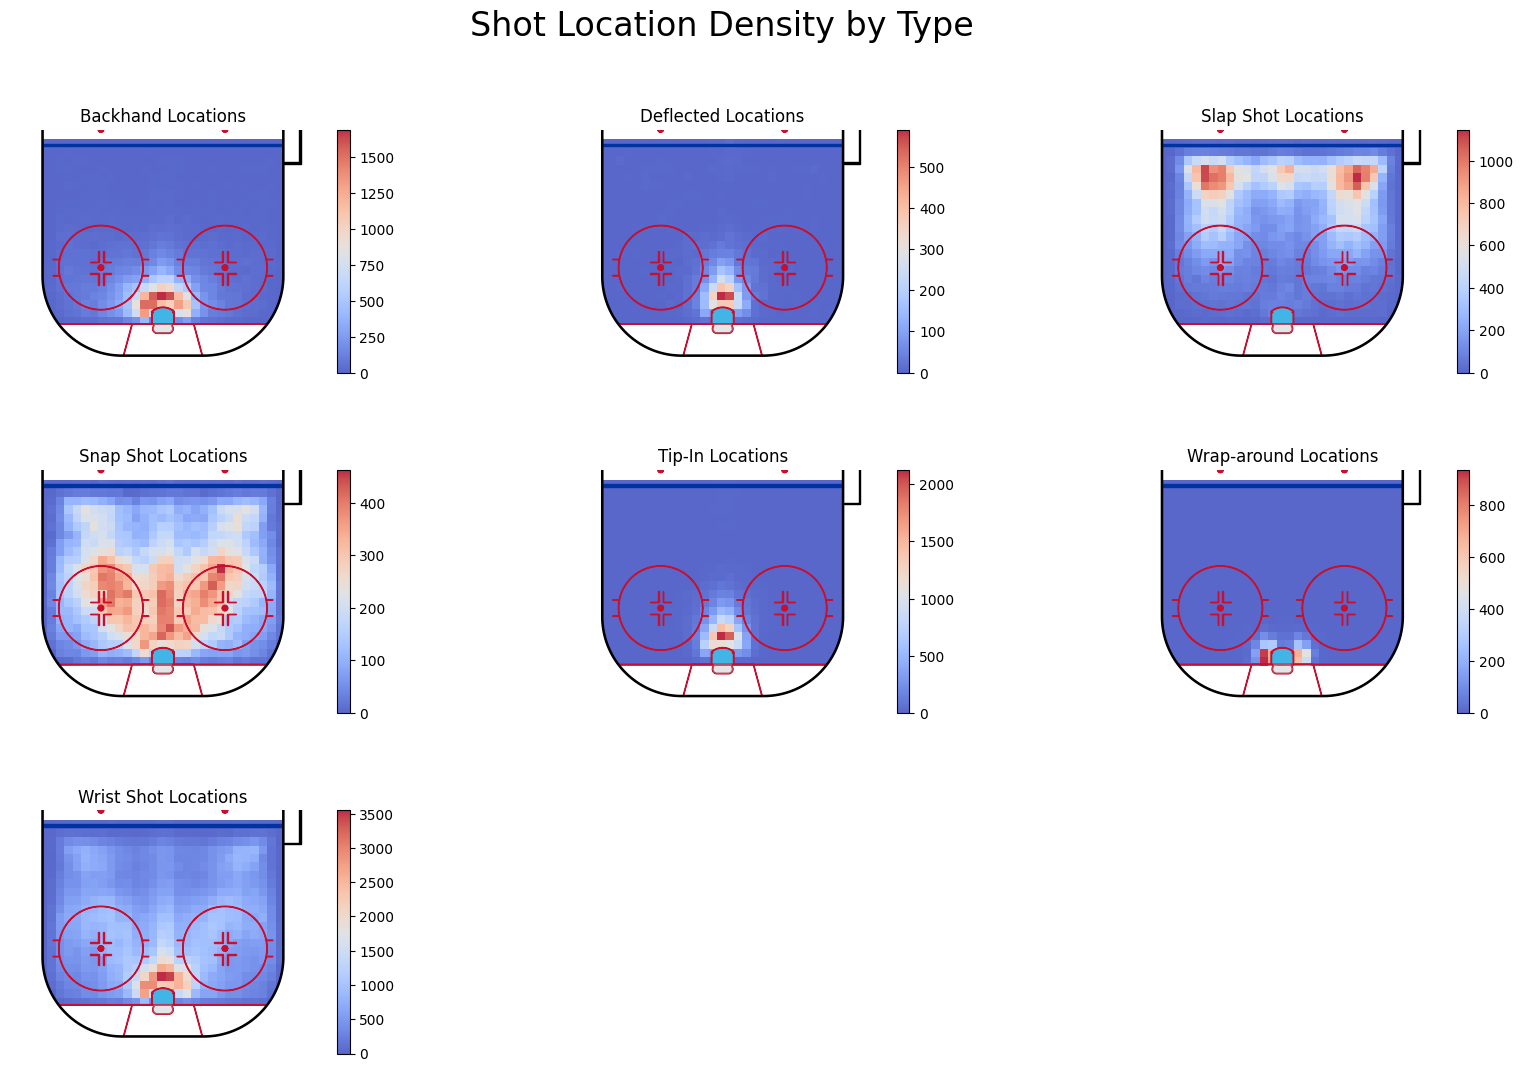

In [47]:
# Get shot types as a list to iterate
shot_types = sorted(list(shots['secondaryType'].unique()))

# prepare the visualization
nhl = NHLRink()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 12),  
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# Only 7 subplots are needed, remove two from the bottom right
fig.delaxes(axes[2,2])
fig.delaxes(axes[2,1])
axes = axes.flatten()[:7]

for i, ax in enumerate(axes):
    # view the shot type we are focused on this loop, axes and shot_types are of same length so we can use i to access
    filtered_shots = shots[shots['secondaryType'] == shot_types[i]]
    
    # display offensive zone where goal is on bottom of image
    nhl.draw(ax, display_range="ozone", rotation=270) 
    
    # plot the heatmap
    heat = nhl.heatmap(
    filtered_shots["xC"],
    filtered_shots["yC"],
    values = filtered_shots["shot"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    plot_xlim=(25, 89),
    binsize=3, 
    alpha=0.85
    )
    plt.colorbar(heat, ax=ax) # add a colorbar
    ax.set_title(f"{shot_types[i]} Locations") # title the axes
    
fig.suptitle("Shot Location Density by Type", fontsize=24)
plt.show()

We can repeat the same technique for goals

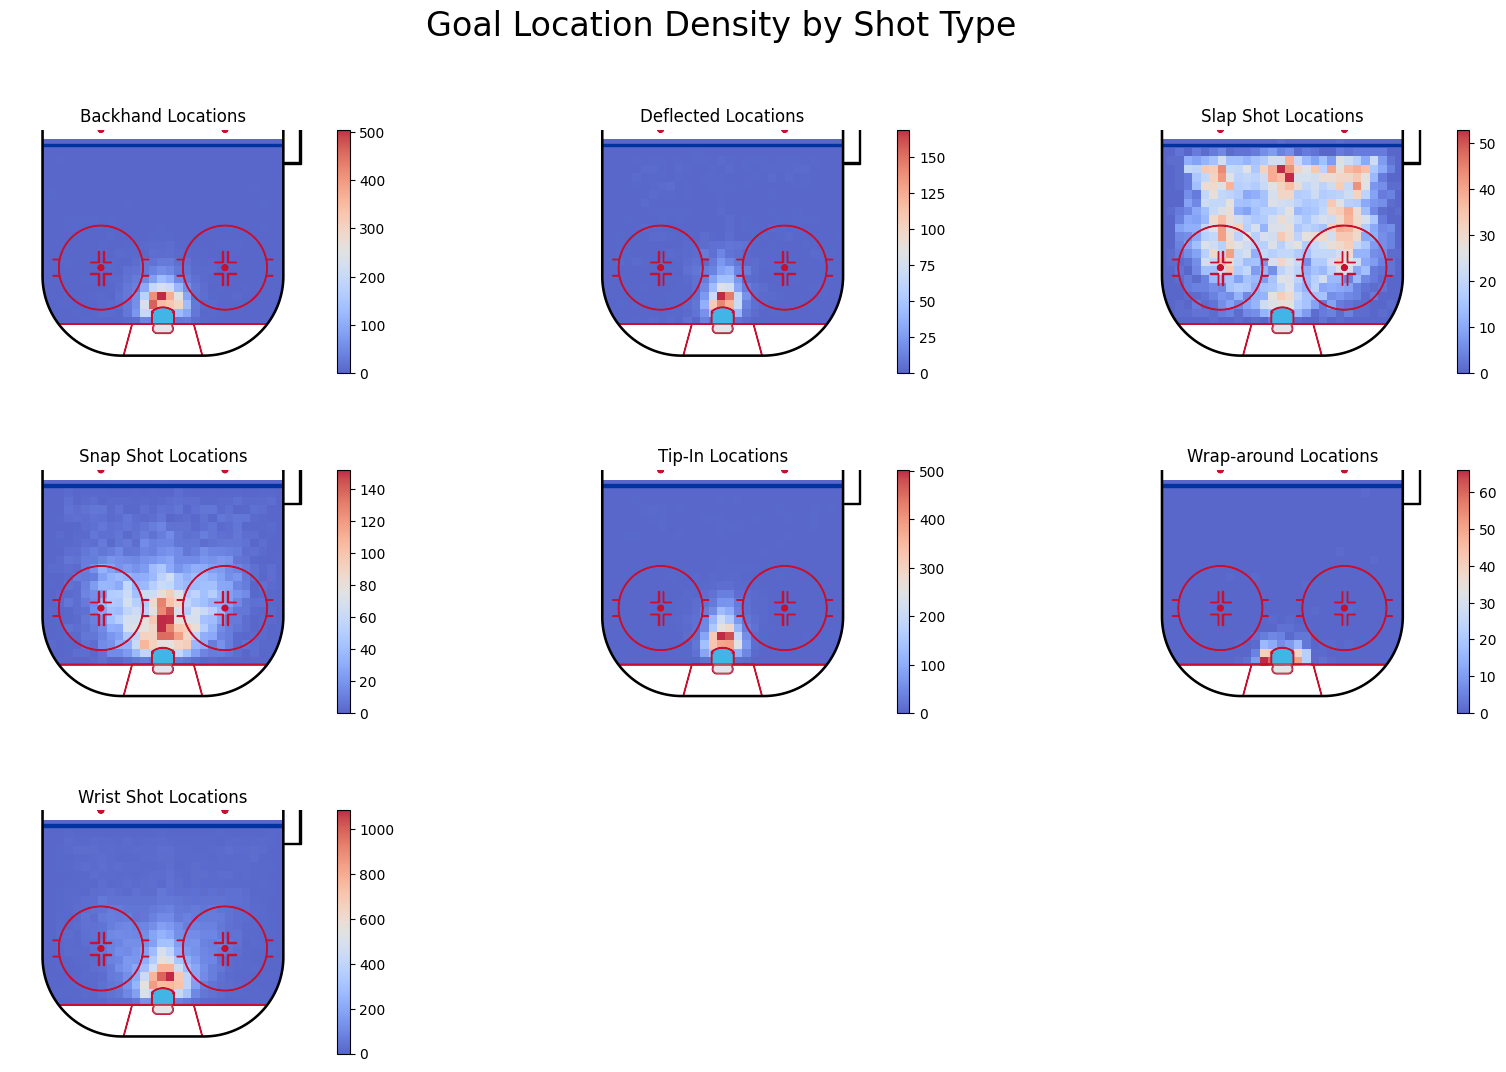

In [52]:
# prepare the visualization
nhl = NHLRink()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 12),  
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# Only 7 subplots are needed, remove two from the bottom right
fig.delaxes(axes[2,2])
fig.delaxes(axes[2,1])
axes = axes.flatten()[:7]

for i, ax in enumerate(axes):
    # view the shot type we are focused on this loop, axes and shot_types are of same length so we can use i to access
    filtered_goals = goals[goals['secondaryType'] == shot_types[i]]
    
    # display offensive zone where goal is on bottom of image
    nhl.draw(ax, display_range="ozone", rotation=270) 
    
    # plot the heatmap
    heat = nhl.heatmap(
    filtered_goals["xC"],
    filtered_goals["yC"],
    values = filtered_goals["goal"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    plot_xlim=(25, 89),
    binsize=3, 
    alpha=0.85
    )
    plt.colorbar(heat, ax=ax) # add a colorbar
    ax.set_title(f"{shot_types[i]} Locations") # title the axes
    
fig.suptitle("Goal Location Density by Shot Type", fontsize=24)
plt.show()

Based on the density plots and histograms above, combined with our domain knowledge of the sport, we observe just above what we expect. Shots are more evenly spread throughout the ice, whereas goals are focused heavily closer to the net and in the center of the ice. By shot type, we see shots coming from where we expect, ie slap shots are most frequently performed by defensemen on offense near the blue line or "the point". Wrist shots are focused close in and between the faceoff circles, or "the slot". Snap shots occur all over as they are a versatile hybrid shot. Others only occur near the net front. Compared to the distribution for shots, goals are much nearer the goal and center as we observed. 